In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import mean_squared_error

#Load the Dataset (Set the index column to the date column)
df = pd.read_csv("Gemini_1INCHUSD_1h.csv", parse_dates = True, index_col = ['date'])
df = df[['open', 'high', 'low', 'close', 'Volume 1INCH', 'Volume USD']]

#Get the first 5 rows of the dataset
df.head(n=5)

,open,high,low,close,Volume 1INCH,Volume USD
date,,,,,,
2022-04-27 00:00:00,1.2871,1.2932,1.2865,1.2888,428.840257,552.689323
2022-04-26 23:00:00,1.2968,1.2970,1.2589,1.2871,1189.529669,1531.043637
2022-04-26 22:00:00,1.3093,1.3124,1.2961,1.2968,1281.291941,1661.579389
2022-04-26 21:00:00,1.2981,1.3116,1.2959,1.3093,2868.856831,3756.194249
2022-04-26 20:00:00,1.3053,1.3095,1.2900,1.2981,2084.128819,2705.407620


In [2]:
'''
Two Modes of Pre-processing: Training split and Forecasting Split
-> Traditional methods of splitting time series data, such using a for-loop or train_test_split method
are all methods that are used for training preprocessing, rather than forecasting preprocessing
-> In order for us to properly implement a LSTM/GRU that forecasts into the future, we must define the outputs as y[t: t + h], 
where y is the time series and h is the length of the forecasting period. (also meaning we must set the output layer = h).
Therefore the inputs would be y[t - Z: t] where Z is the length of the lookback period/# of timesteps 
-> Let's implement both methods method
'''

from sklearn.preprocessing import MinMaxScaler

#Define a Test Size
test_size = int(0.8 * len(df)) #80% for the training, 20% testing

#Split the data into Training and Testing
train = df.iloc[:test_size]
test = df.iloc[test_size:]

#Scale the Data using the MinMaxScaler (Transforms the features by giving each feature a value between a given range)
mms_scaler = MinMaxScaler(feature_range = (0,1))
train_scaled = mms_scaler.fit_transform(train)
test_scaled = mms_scaler.fit_transform(test)

'''
For training splits, since LSTMs are long short term memory states, 
we must create a data structure with 60 timesteps and 1 output
-> basically, for each element of a training set we will have 60 previous training elements
'''
def training_split(df_scaled, steps):
    X_train, y_train = [], [] 
    for i in range(steps, df_scaled.shape[0] - steps):
        X_train.append(df_scaled[i - steps:i, :]) #Training split for Timesteps
        y_train.append(df_scaled[i, :]) #Training Split for 
    X_train, y_train = np.array(X_train), np.array(y_train)
    return X_train, y_train

In [3]:
'''
For forecast splits, using a similar concept as the training split,
however we must define the set the outputs equal to i + n_forecast so that it forecasts into the future 
rather on the validation data that is given.
The input data must be i - n_lookback so it is able to forecast a specified number of periods based off of
a lookback periods defined in the splitting method.
'''
def forecasting_split(y, n_lookback, n_forecast):
    X_train, y_train = [], []
    for i in range(n_lookback, len(y) - n_forecast + 1):
        X_train.append(y[i - n_lookback:i])
        y_train.append(y[i: i + n_forecast])
    X_train, y_train = np.array(X_train), np.array(y_train)
    return X_train, y_train

In [4]:
#60 timesteps per output
X_traint, y_traint = training_split(train_scaled, 60)
X_testt, y_testt = training_split(test_scaled, 60)
print("Train Split Shapes: ", X_traint.shape, y_traint.shape, X_testt.shape, y_testt.shape)

#Forecast 30 days into the future given a lookback period of 60
y = df['Volume USD'].to_numpy().reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

X_trainf, y_trainf = forecasting_split(y, 60, 30)
X_testf, y_testf = forecasting_split(y, 60, 30)
print("Forecasting Split Shapes: ", X_trainf.shape, y_trainf.shape, X_testf.shape, y_testf.shape)

Train Split Shapes:  (1452, 60, 6) (1452, 6) (273, 60, 6) (273, 6)
Forecasting Split Shapes:  (1876, 60, 1) (1876, 30, 1) (1876, 60, 1) (1876, 30, 1)


In [5]:
'''
Training Model on X_traint -> via training split
'''
model_tm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, return_sequences = True, input_shape = (X_traint.shape[1], 6)), #input shape contains the 2nd values for the shape of the training data
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(6)]) #Output shape equals number of columns in df

'''
Training Model on X_trainf -> via forecasting split
'''
n_lookback, n_forecast = 60, 30
model_fm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, return_sequences = True, input_shape = (n_lookback, 1)), #input shape contains the 2nd values for the shape of the training data
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(n_forecast)
])

In [6]:
model_tm.compile(loss = 'mse', optimizer = 'adam')
model_tm.fit(X_traint, y_traint, epochs = 50, batch_size = 32)

Epoch 1/50
46/46 [==============================] - 9s 62ms/step - loss: 0.0490
Epoch 2/50
46/46 [==============================] - 3s 61ms/step - loss: 0.0104
Epoch 3/50
46/46 [==============================] - 3s 64ms/step - loss: 0.0066
Epoch 4/50
46/46 [==============================] - 3s 66ms/step - loss: 0.0061
Epoch 5/50
46/46 [==============================] - 3s 63ms/step - loss: 0.0063
Epoch 6/50
46/46 [==============================] - 3s 62ms/step - loss: 0.0058
Epoch 7/50
46/46 [==============================] - 3s 72ms/step - loss: 0.0051
Epoch 8/50
46/46 [==============================] - 3s 71ms/step - loss: 0.0049
Epoch 9/50
46/46 [==============================] - 3s 73ms/step - loss: 0.0038
Epoch 10/50
46/46 [==============================] - 3s 67ms/step - loss: 0.0043
Epoch 11/50
46/46 [==============================] - 3s 67ms/step - loss: 0.0038
Epoch 12/50
46/46 [==============================] - 3s 68ms/step - loss: 0.0037
Epoch 13/50
46/46 [==================

In [7]:
model_fm.compile(loss = 'mse', optimizer = 'adam')
model_fm.fit(X_trainf, y_trainf, epochs = 50, batch_size = 32)

Epoch 1/50
59/59 [==============================] - 9s 62ms/step - loss: 0.0032
Epoch 2/50
59/59 [==============================] - 4s 60ms/step - loss: 0.0029
Epoch 3/50
59/59 [==============================] - 4s 61ms/step - loss: 0.0029
Epoch 4/50
59/59 [==============================] - 4s 61ms/step - loss: 0.0030
Epoch 5/50
59/59 [==============================] - 4s 63ms/step - loss: 0.0030
Epoch 6/50
59/59 [==============================] - 4s 66ms/step - loss: 0.0029
Epoch 7/50
59/59 [==============================] - 4s 67ms/step - loss: 0.0027
Epoch 8/50
59/59 [==============================] - 4s 64ms/step - loss: 0.0028
Epoch 9/50
59/59 [==============================] - 4s 61ms/step - loss: 0.0029
Epoch 10/50
59/59 [==============================] - 4s 61ms/step - loss: 0.0028
Epoch 11/50
59/59 [==============================] - 4s 66ms/step - loss: 0.0028
Epoch 12/50
59/59 [==============================] - 4s 71ms/step - loss: 0.0028
Epoch 13/50
59/59 [==================

In [12]:
import os

HORIZON, WINDOW_SIZE = 1, 7

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name), 
                                            verbose = 0, 
                                            save_best_only = True) 

inputs = tf.keras.layers.Input(shape=(WINDOW_SIZE))
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) 
x = tf.keras.layers.LSTM(128, activation="relu", return_sequences=True)(x) 
x = tf.keras.layers.LSTM(128, activation="relu")(x) 
x = tf.keras.layers.Dense(32, activation="relu")(x)
output = tf.keras.layers.Dense(HORIZON)(x)
model_lstm = tf.keras.Model(inputs=inputs, outputs=output, name="model_lstm")

model_lstm.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_lstm.fit(train_windows, train_labels, epochs=100, verbose=0, batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name = model_lstm.name)])

INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets


In [13]:
model_lstm = tf.keras.models.load_model("model_experiments/model_lstm/")
model_lstm.evaluate(test_windows, test_labels)

def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

model_lstm_preds = make_preds(model_lstm, test_windows)
model_lstm_preds[:10]

13/13 [==============================] - 0s 2ms/step - loss: 0.0136


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.4905509, 1.4907447, 1.4887158, 1.4885603, 1.4850461, 1.4889389,
       1.4866539, 1.4877504, 1.4909238, 1.4988786], dtype=float32)>

In [14]:
model_lstm_preds = np.array(model_lstm_preds)

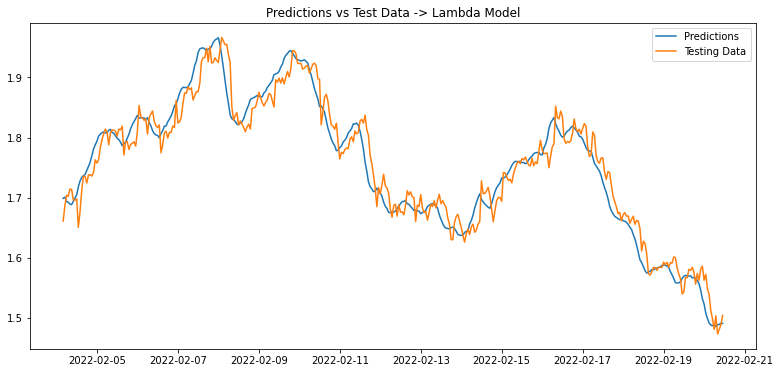

In [20]:
fig, ax = plt.subplots(figsize = (13, 6))
ax.plot(X_test[1:], model_lstm_preds, label = "Predictions")
ax.plot(X_test[1:], y_test[1:], label = "Testing Data")
ax.set_title("Predictions vs Test Data -> Lambda Model")
ax.legend()